In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model, insert_attention_layer_in_keras, insert_standard_attention_layer_in_keras
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from models.layers import ProjectionAttentionLayer
from typing import List
import pymf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [10]:
# Set configs
img_height = 224
img_width = 224
batch_size = 128

test_datagen = CustomDataGenerator(
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet test-set
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [3]:
# Load pre-trained VGG-16 model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False

# Get layer kernel
kernel = model.get_layer('block4_conv3').kernel
flat_kernel = tf.reshape(kernel, [-1, kernel.shape[-1]]).numpy()

In [ ]:
# Perform dimensionality-reduction through SNMF on the flattened kernel and save for use within all experiments
p_mat_dict = {}

for dim in [17, 42, 90, 256, 512]:
    # Get projection matrix via SNMF
    n_comp = dim

    nmf = pymf.SNMF(flat_kernel, num_bases=n_comp)
    nmf.factorize(niter=1000)
    
    # Normalise columns of W using max norm
    d = np.diag(np.max(np.abs(nmf.W), axis=0))
    p_mat = d@nmf.H

    p_mat_dict[dim] = p_mat

In [ ]:
# Export dict
import pickle
with open('external_files/generated_saves/proj_mats_norm.pkl', 'wb') as f:
    pickle.dump(p_mat_dict, f)

In [7]:
# Load dict
with open('external_files/generated_saves/proj_mats_norm.pkl', 'rb') as f:
    p_mat_dict  = pickle.load(f)

In [8]:
classes = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849', 'n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743'] 
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849']
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']

In [ ]:
acc = [pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256, 512]) for i in range(3)]
acc_baseline = [pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256, 512]) for i in range(3)]
#sparsity = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
ws = []

for cl in classes:
    for i in range(3):
        acc[i] = acc[i].append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
        acc_baseline[i] = acc_baseline[i].append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #sparsity = sparsity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

#Begin the hit-rate tests for each class (baseline)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for j, i in enumerate(['', '2', '3']):
        model.load_weights(f'models/baseline_fixed/{dim}/model_weights{i}')
        for cl in classes:
            test_set.set_target_sampling([cl], [1])
            acc_val = test_model(model, test_set, cl)
            acc_baseline[j].loc[classes.index(cl), dim] = acc_val

# Begin the hit-rate tests for each class (target)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        test_set.set_target_sampling([cl], [1])
        for j, i in enumerate(['', '2', '3']):
            model.load_weights(f'models/task_models_fixed/{cl}/{str(dim)}/model_weights{i}')
            acc_val = test_model(model, test_set, cl)
            acc[j].loc[classes.index(cl), dim] = acc_val

# Begin the hit-rate tests for the standard attention mechanism models
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
model = insert_standard_attention_layer_in_keras(model, ['block5_conv1'])

for cl in classes:
    test_set.set_target_sampling([cl], [1])
    for j, i in enumerate(['', '2', '3']):
        model.load_weights(f'models/task_models_standard/{cl}/model_weights{i}')
        acc_val = test_model(model, test_set, cl)
        acc[j].loc[classes.index(cl), '512-S'] = acc_val

Sensitivity model

In [14]:
def fp_model(model, test_set: CustomIterator, cl) -> None:
    """ Test the passed model for its false-positive rate on the passed test set. 

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    cls = []
    for idx in test_set.index_array:
        for k, v in test_set.cls_to_file_idx.items():
            if idx in test_set.cls_to_file_idx[k]:
                cls.append(k)
    cls = np.array(cls)
    
    print('Computing rates...')
    not_target = np.where(cls!=test_set.class_indices[cl])[0]
    new_pred = pred[not_target]
    fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)
    #accuracy = np.sum(pred == test_set.class_indices[cl])/len(pred)

    return fp_val

In [12]:
# def fp_model(model, test_set: CustomIterator, cl) -> None:
#     """ Test the passed model for its false-positive rate on the passed test set.

#     Args:
#         model (Model): TensorFlow model.
#         test_set (CustomIterator): Test set to test on.
#     """
#     test_set.reset()
#     pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
#     pred = np.argmax(pred, axis=-1)
#     cls = np.array(test_set.classes)
    
#     print('Computing rates...')
#     not_target = np.where(cls!=test_set.class_indices[cl])[0]
#     new_pred = pred[not_target]
#     fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)
#     #accuracy = np.sum(pred == test_set.class_indices[cl])/len(pred)

#     return fp_val

In [ ]:
test_set.reset_target_sampling()
# # global_acc = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
# # global_acc_base = []
# #hr_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
# fp = [pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256, 512]) for i in range(3)]
# fp_baseline = [pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256, 512]) for i in range(3)]

# for cl in classes:
#     #global_acc = global_acc.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
#     #hr_baseline = hr_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
#     for i in range(3):
#         fp[i] = fp[i].append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0, 512:0}, ignore_index=True)
#         fp_baseline[i] = fp_baseline[i].append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# #Begin the tests for each class (baseline)
# for dim in [17, 42, 90, 256, 512]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     for j, i in enumerate(['', '2', '3']):
#         model.load_weights(f'models/baseline_fixed/{dim}/model_weights')

#         # pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
#         # pred = np.argmax(pred, axis=-1)
#         # cls = np.array(test_set.classes)

#         print('Computing rates...')
#         for cl in classes:
#             test_set.set_target_sampling([cl], [0.5], force_class_sampling=True)
#             # not_target = np.where(cls!=test_set.class_indices[cl])[0]
#             # new_pred = pred[not_target]
#             # fp_val = np.sum(new_pred==test_set.class_indices[cl])/len(new_pred)
#             fp_val = fp_model(model, test_set, cl)
#             fp_baseline[j].loc[classes.index(cl), dim] = fp_val

# #Begin the tests for each class (target)
# for dim in [17, 42, 90, 256, 512]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     for cl in classes:
#         for j, i in enumerate(['', '2', '3']):
#             test_set.set_target_sampling([cl], [0.5], force_class_sampling=True)
#             model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights{i}', )
#             fp_val = fp_model(model, test_set, cl)
#             fp[j].loc[classes.index(cl), dim] = fp_val
#             #global_acc.loc[classes.index(cl), dim] = acc_val

# Begin the tests for standard attention mechanism models
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
model = insert_standard_attention_layer_in_keras(model, ['block5_conv1'])

for cl in classes:
    for j, i in enumerate(['', '2', '3']):
        test_set.set_target_sampling([cl], [0.5], force_class_sampling=True)
        model.load_weights(f'models/task_models_standard/{cl}/model_weights{i}', )
        fp_val = fp_model(model, test_set, cl)
        fp[j].loc[classes.index(cl), '512-S'] = fp_val
        #global_acc.loc[classes.index(cl), dim] = acc_val

In [12]:
# Save metrics
for i in range(3):
    acc[i].to_csv(f'acc{i}.csv', index=False)
    acc_baseline[i].to_csv(f'acc_baseline{i}.csv', index=False)
    fp_baseline[i].to_csv(f'false_alarm_base{i}.csv', index=False)
    fp[i].to_csv(f'false_alarm{i}.csv', index=False)

Plots

In [2]:
dims = [17,42,90,256, 512, '512-S']

In [3]:
# Load metrics
acc = []
fp = []
acc_baseline = []
fp_baseline = []

for i in range(3):
    acc.append(pd.read_csv(f'external_files/generated_saves/acc{i}.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0))
    fp.append(pd.read_csv(f'external_files/generated_saves/false_alarm{i}.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0))
    acc_baseline.append(pd.read_csv(f'external_files/generated_saves/acc_baseline{i}.csv', names=['group', 'class',17, 42, 90, 256, 512], header=0))
    fp_baseline.append(pd.read_csv(f'external_files/generated_saves/false_alarm_base{i}.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0))

Perceptual Boosts

[0.00508474 0.00689277 0.00852261 0.01129401 0.01346313] [0.03149926 0.05460637 0.08042503 0.12944452 0.14092381]


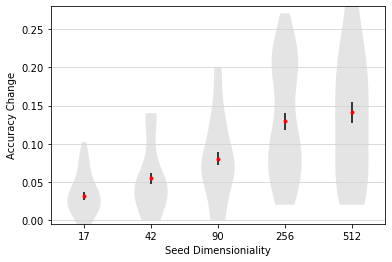

In [14]:
acc_change = np.vstack([acc[i][dims] for i in range(3)]) - np.tile(acc_baseline[0][dims], (3,1))

means = np.mean(acc_change, axis=0)
errors = np.std(acc_change, axis=0)/np.sqrt(acc_change.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[acc_change[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
#ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
#ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
#ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = means.tolist()
m.insert(0,0)
e = errors.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel('Accuracy Change')
ax.set_ylim([-0.005,0.28])
ax.set_xlim([0.5,5.5])
#fig.savefig('acc_change_per_dim_vio.png', dpi=300)

print(errors, means)

Student T-test on descending pairs

In [18]:
acc_sens = np.std(acc_change, axis=0)
for pair in [[4, 3], [3, 2], [2,1], [1,0]]:
    s2 = (41*(acc_sens[pair[0]]**2) + 41*(acc_sens[pair[1]]**2))/(42+42-2)
    t = (means[pair[0]] - means[pair[1]])/(np.sqrt((2*s2)/42))
    print(acc_sens[pair[0]]/acc_sens[pair[1]], t)

1.1659304394612298 0.39309994066441156
1.382407700680895 3.6924867494252887
1.1224189806618972 2.0202649463339304
1.6178893785579145 3.4077077788259325


Perceptual boost increases with dimensionality from 17 to 512. The highest perceptual boost was exhibited by dimensionality 512, however this was found to not be significant t(82)=0.39, p>0.5 suggesting that both 512 and 256 operate with equal performance meaning there are around 256 redundant dimensions within the original decomposition as the seed mechanism at 50% reduction in dimensionality performs as well as the full dimensionality equivalent. The difference between the 256 and 90 dimensional models was found to be significant at t(82)=3.69, p<0.001 suggesting optimal dimensionality for the mechanism is the 256 dimensional model. All subsequent sensitivites we also found to be significant. Perceptual boost at all dimensions is apparent and provides evidence for the success of the mechanism, especially the 512-256 pair. Note that the overall mean accuracy at higher dimensions decreased after constraining the clipping to be non-negative as these dims tended to go negative- possibly look into new constraining techniques.

Perceptual Boosts on a continuous x-axis

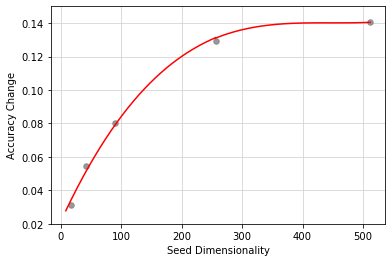

In [67]:
#acc_change = np.array(acc[dims]) - np.array(acc_baseline[dims])
x = [i for i in dims]*14
x_quad = np.hstack([np.array(dims).reshape(-1, 1), np.array(dims).reshape(-1, 1)**2])
x_new = np.linspace(0, 512, 50).reshape(-1, 1)
x_new = np.hstack([x_new, x_new**2])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)

reg = LinearRegression().fit(np.vstack([x_quad, np.flip(x_quad, axis=0)]), np.hstack([means, np.flip(means)]).reshape(-1, 1))
ax.scatter(np.array(dims).flatten(), means.flatten(), marker='o', alpha=0.8, color='grey', s=30)
#ax.plot(x_new[:, 0], reg.predict(x_new), 'r', label='Linear Fit')
neww = dims.copy()
newwm = means.tolist()
for i in range(20): 
    neww.append(512+i*3)
    newwm.append(0.14092381)
# neww.insert(0, 0)
# newwm.insert(0,0)
spl = UnivariateSpline(neww, newwm, k=3)
xs = np.linspace(8, 256, 1000)
plt.plot(xs, spl(xs), 'r')
neww = dims.copy()
newwm = means.tolist()
for i in range(20): 
    neww.append(512+i*2)
    newwm.append(0.14092381)
spl = UnivariateSpline(neww, newwm, k=3)
xs = np.linspace(256, 512, 1000)
plt.plot(xs, spl(xs), 'r')

ax.grid(color='lightgrey', linestyle='-', axis='both')
ax.set_xlabel('Seed Dimensionality')
ax.set_ylabel('Accuracy Change')
ax.set_ylim([0.02, 0.15])
fig.savefig('acc_change_per_all_dims.png', dpi=300)

Signal 

[0.02005009 0.01840674 0.01704584 0.01384811 0.01424992 0.01151201]
1.0717742202659248 0.43475608153752054


Text(0.5, 0.075, 'Seeds Dimesionality')

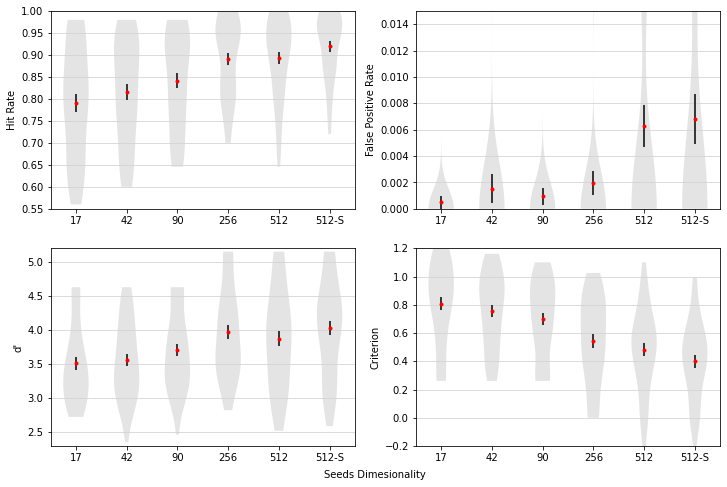

In [18]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(12,8))
dims = [17, 42, 90, 256, 512, '512-S']

hr_arr = np.vstack([acc[i][dims] for i in range(3)])

#HR
me_hr = np.mean(hr_arr, axis=0)
err_hr = np.std(hr_arr, axis=0)/np.sqrt(hr_arr.shape[0]) # Compute standard error
print(err_hr)

ax1[0].set_axisbelow(True)
data=[hr_arr[:,i] for i in range(6)]
ax1[0].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax1[0].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax1[0].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax1[0].set_xticklabels(['17', '42', '90', '256', '512', '512-S'])

d = ['17', '42', '90', '256', '512', '512-S']
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax1[0].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax1[0].set_ylabel("Hit Rate")
ax1[0].set_ylim([0.55, 1])
ax1[0].set_xlim([0.55,5.5])

# FP
fp_arr = np.vstack([fp[i][dims] for i in range(3)])
me_hr = np.mean(fp_arr, axis=0)
err_hr = np.std(fp_arr, axis=0)/np.sqrt(fp_arr.shape[0]) # Compute standard error

ax1[1].set_axisbelow(True)
data=[fp_arr[:,i] for i in range(6)]
ax1[1].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax1[1].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax1[1].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax1[1].set_xticklabels(['17', '42', '90', '256', '512', '512-S'])

d = ['17', '42', '90', '256', '512', '512-S']
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax1[1].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax1[1].set_ylabel("False Positive Rate")
ax1[1].set_ylim([0, 0.015])
ax1[1].set_xlim([0.5,5.5])

#SENSE
from scipy.stats import norm
sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
for cl in classes:
    sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

hr_arr = np.vstack([acc[i][dims] for i in range(3)])
hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
fp_arr = np.vstack([fp[i][dims] for i in range(3)])
fp_arr[np.where(fp_arr<0.005)[0], np.where(fp_arr<0.005)[1]] = 0.005
z_hr = norm.ppf(hr_arr)
z_fp = norm.ppf(fp_arr)
sens = z_hr - z_fp
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error
acc_sens = np.std(sens, axis=0)
for pair in [[5, 3]]:
    s2 = (41*(acc_sens[pair[0]]**2) + 41*(acc_sens[pair[1]]**2))/(42+42-2)
    t = (me_sen[pair[0]] - me_sen[pair[1]])/(np.sqrt((2*s2)/42))
    print(acc_sens[pair[0]]/acc_sens[pair[1]], t)

ax2[0].set_axisbelow(True)
data=[sens[:,i] for i in range(6)]
ax2[0].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax2[0].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax2[0].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax2[0].set_xticklabels(['17', '42', '90', '256', '512', '512-S'])

d = ['17', '42', '90', '256', '512', '512-S']
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax2[0].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax2[0].set_ylabel("d'")
ax2[0].set_ylim([2.3,5.2])
ax2[0].set_xlim([0.5,5.5])

# Cri
sens = - (z_hr + z_fp) / 2
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error

ax2[1].set_axisbelow(True)
data=[sens[:,i] for i in range(6)]
ax2[1].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax2[1].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax2[1].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax2[1].set_xticklabels(['17', '42', '90', '256', '512', '512-S'])

d = ['17', '42', '90', '256', '512', '512-S']
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax2[1].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax2[1].set_ylabel("Criterion")
ax2[1].set_ylim([-0.2,1.2])
ax2[1].set_xlim([0.5,5.5])

ax1[0].set_xlim([0.5,6.5])
ax1[1].set_xlim([0.5,6.5])
ax2[0].set_xlim([0.5,6.5])
ax2[1].set_xlim([0.5,6.5])

fig.text(0.5, 0.075, 'Seeds Dimesionality', ha='center', va='center')
#fig.savefig('all_signal.png', bbox_inches='tight', dpi=300)

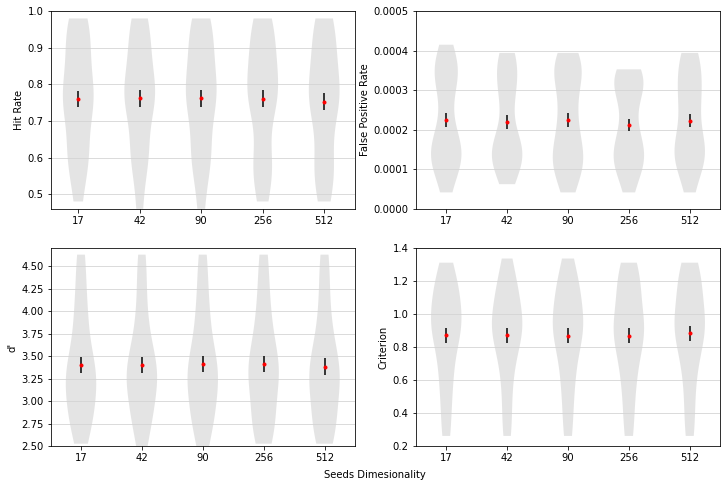

In [45]:
dims = [17, 42, 90, 256, 512]
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(12,8))
hr_arr = np.vstack([acc_baseline[i][dims] for i in range(3)])
hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
fp_arr = np.vstack([fp_baseline[i][dims] for i in range(3)])

#HR
me_hr = np.mean(hr_arr, axis=0)
err_hr = np.std(hr_arr, axis=0)/np.sqrt(hr_arr.shape[0]) # Compute standard error

ax1[0].set_axisbelow(True)
data=[hr_arr[:,i] for i in range(5)]
ax1[0].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax1[0].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax1[0].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax1[0].set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax1[0].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax1[0].set_ylabel("Hit Rate")
ax1[0].set_ylim([0.46, 1])
ax1[0].set_xlim([0.55,5.5])

# FP
fp_arr = np.vstack([fp_baseline[i][dims] for i in range(3)])
me_hr = np.mean(fp_arr, axis=0)
err_hr = np.std(fp_arr, axis=0)/np.sqrt(fp_arr.shape[0]) # Compute standard error

ax1[1].set_axisbelow(True)
data=[fp_arr[:,i] for i in range(5)]
ax1[1].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax1[1].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax1[1].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax1[1].set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax1[1].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax1[1].set_ylabel("False Positive Rate")
ax1[1].set_ylim([0, 0.0005])
ax1[1].set_xlim([0.5,5.5])

#SENSE
from scipy.stats import norm
sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
for cl in classes:
    sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

hr_arr = np.vstack([acc_baseline[i][dims] for i in range(3)])
hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
fp_arr = np.vstack([fp_baseline[i][dims] for i in range(3)])
fp_arr[np.where(fp_arr<0.005)[0], np.where(fp_arr<0.005)[1]] = 0.005
z_hr = norm.ppf(hr_arr)
# z_fp = np.ones_like(fp_arr)
# for i in range(fp_arr.shape[0]):
#     for j in range(fp_arr.shape[1]):
#         z_fp[i, j] = norm.ppf(fp_arr[i,j])
z_fp = norm.ppf(fp_arr)
sens = z_hr - z_fp
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error


#ax.errorbar([str(x) for x in dims], me_sen, yerr=err_sen, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)
ax2[0].set_axisbelow(True)
data=[sens[:,i] for i in range(5)]
ax2[0].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax2[0].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax2[0].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax2[0].set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax2[0].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

#ax2[0].set_xlabel('Seed Dimensioniality')
ax2[0].set_ylabel("d'")
ax2[0].set_ylim([2.5,4.7])
ax2[0].set_xlim([0.5,5.5])


# Cri
sens = - (z_hr + z_fp) / 2
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error

ax2[1].set_axisbelow(True)
data=[sens[:,i] for i in range(5)]
ax2[1].grid(color='lightgrey', linestyle='-', axis='y')
parts = ax2[1].violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax2[1].set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax2[1].set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax2[1].errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax2[1].set_ylabel("Criterion")
ax2[1].set_ylim([0.2,1.4])
ax2[1].set_xlim([0.5,5.5])

fig.text(0.5, 0.075, 'Seeds Dimesionality', ha='center', va='center')
fig.savefig('all_signal_base.png', bbox_inches='tight', dpi=300)

Metrics Computed In Single Graphs

[0.09064118 0.08810472 0.08968768 0.10248995 0.11467786] [3.51081627 3.56874009 3.70413381 3.96595682 3.87596735]


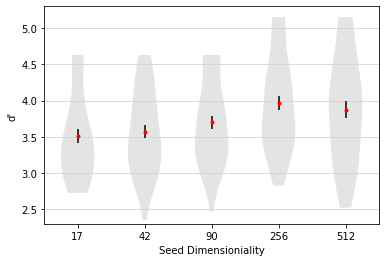

In [29]:
from scipy.stats import norm
sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
for cl in classes:
    sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

hr_arr = np.vstack([acc[i][dims] for i in range(3)])
hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
fp_arr = np.vstack([fp[i][dims] for i in range(3)])
fp_arr[np.where(fp_arr<0.005)[0], np.where(fp_arr<0.005)[1]] = 0.005
z_hr = norm.ppf(hr_arr)
z_fp = norm.ppf(fp_arr)
sens = z_hr - z_fp
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error


#ax.errorbar([str(x) for x in dims], me_sen, yerr=err_sen, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[sens[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("d'")
ax.set_ylim([2.3,5.3])
ax.set_xlim([0.5,5.5])

#fig.savefig('sens_per_dim_vio.png', dpi=300)

print(err_sen, me_sen)

Student T-test on decreasing pairs

In [17]:
std_sens = np.std(sens, axis=0)
for pair in [[3, 4], [4, 2], [2,1], [1,0]]:
    s2 = (41*(std_sens[pair[0]]**2) + 41*(std_sens[pair[1]]**2))/(42+42-2)
    t = (me_sen[pair[0]] - me_sen[pair[1]])/(np.sqrt((2*s2)/42))
    print(t)

0.5850976713754943
1.180299771230999
1.076919185048545
0.45823936361189554


Model sensitivity peaked at 256 dimensionality, followed closely by 512 which speaks to more redundancies of the full dimensionality attention. Following these we see the next highest at 90, 42 and finally 17. All sensitivites to fall within the same range and match those found in Luo et al hence showing consistency in the balance of benefits and costs of the attention mechanism. A student t-test between the decreasing pairs of sensitivities reveals the null hypothesis that there is a difference between subsequent sensitivity means is under 50% or less than pure chance and max confidence exhibited at t(81)=1.18, p<0.3.

Criterion

[0.04571681 0.04161344 0.04320074 0.04799147 0.04585937] [0.80779169 0.75829193 0.69890143 0.54231853 0.48026056]


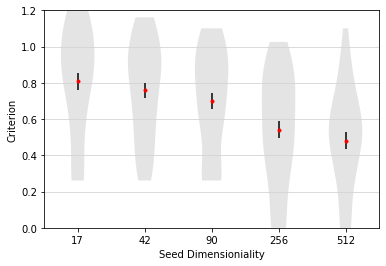

In [17]:
# from scipy.stats import norm
# sensitivity = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
# for cl in classes:
#     sensitivity = sensitivity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# hr_arr = np.array(acc[dims])
# hr_arr[np.where(hr_arr>0.995)[0], np.where(hr_arr>0.995)[1]] = 0.995
# fp_arr = np.array(fp[dims])
# z_hr = norm.ppf(hr_arr)
# z_fp = norm.ppf(fp_arr)
sens = - (z_hr + z_fp) / 2
me_sen = np.mean(sens, axis=0)
err_sen = np.std(sens, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error


#ax.errorbar([str(x) for x in dims], me_sen, yerr=err_sen, fmt='o', color='red', ecolor='grey', elinewidth=2.5, markersize=4)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[sens[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

# vp = parts['cmeans']
# vp.set_edgecolor('red')
# vp.set_linewidth(1)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_sen.tolist()
m.insert(0,0)
e = err_sen.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("Criterion")
ax.set_ylim([0,1.2])
ax.set_xlim([0.5,5.5])

fig.savefig('cri_per_dim_vio.png', dpi=300)

print(err_sen, me_sen)

Decreasing model
criterion suggests that as seed dimensionality increased,
the model was more biased in favour of a target class
response, which was more likely to result in a false
alarm

Hit-Rate

[0.02005009 0.01840674 0.01704584 0.01371589 0.01412471] [0.79133227 0.81598829 0.8417778  0.88999311 0.89268823]


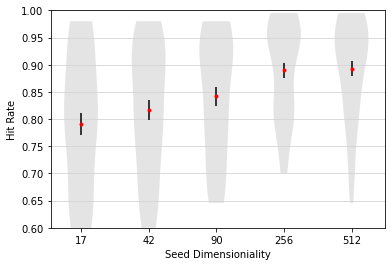

In [36]:
me_hr = np.mean(hr_arr, axis=0)
err_hr = np.std(hr_arr, axis=0)/np.sqrt(sens.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[hr_arr[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("Hit Rate")
ax.set_ylim([0.6, 1])
ax.set_xlim([0.55,5.5])
print(err_hr, me_hr)
fig.savefig('hr_per_dim_vio.png', dpi=300)

False-positive rate

[0.00048009 0.00110378 0.00065721 0.00092531 0.00159019] [0.00048591 0.0015092  0.00095238 0.00194488 0.0062496 ]


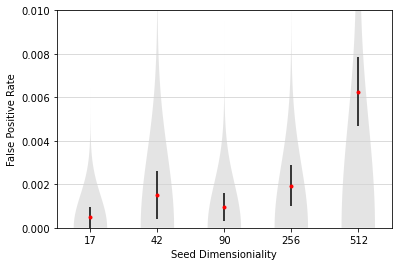

In [12]:
fp_arr = np.vstack([fp[i][dims] for i in range(3)])
me_hr = np.mean(fp_arr, axis=0)
err_hr = np.std(fp_arr, axis=0)/np.sqrt(fp_arr.shape[0]) # Compute standard error

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
data=[fp_arr[:,i] for i in range(5)]
ax.grid(color='lightgrey', linestyle='-', axis='y')
parts = ax.violinplot(data ,showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#D3D3D3')
    #pc.set_edgecolor('red')
    pc.set_alpha(0.6)
for partname in ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp.set_alpha(0)

ax.set_xticks(np.arange(1, len([str(dim) for dim in dims]) + 1))
ax.set_xticklabels([str(dim) for dim in dims])

d = [str(x) for x in dims]
d.insert(0, '0')
m = me_hr.tolist()
m.insert(0,0)
e = err_hr.tolist()
e.insert(0,0)
ax.errorbar(d, m, yerr=e, fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)

ax.set_xlabel('Seed Dimensioniality')
ax.set_ylabel("False Positive Rate")
ax.set_ylim([0, 0.01])
ax.set_xlim([0.5,5.5])

print(err_hr, me_hr)
#fig.savefig('fp_per_dim_vio.png', dpi=300)

Attention Weights

In [5]:
s = {512:[],17:[], 42:[], 90:[], 256:[]}
p = {512:[],17:[], 42:[], 90:[], 256:[]}
s_b = {512:[],17:[], 42:[], 90:[], 256:[]}
p_b = {512:[],17:[], 42:[], 90:[], 256:[]}

# # Begin the tests for each class (baseline)
# for dim in [17, 42, 90, 256]:
#     model = tf.keras.models.load_model('models/vgg_trained')
#     model.trainable = False
#     model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

#     model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        for j, i in enumerate(['', '2', '3']):
            model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights{i}')
            s[dim].extend(model.get_layer('attention_block5_conv1').seeds.numpy().tolist())
            p[dim].extend((model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias).numpy().tolist())
    
    # Baselines
    for j, i in enumerate(['', '2', '3']):
        model.load_weights(f'models/baseline_fixed/{dim}/model_weights{i}')
        s_b[dim].extend(model.get_layer('attention_block5_conv1').seeds.numpy().tolist())
        p_b[dim].extend((model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias).numpy().tolist())

[0.04402432277028887, 0.031219062784685343, 0.04499613689514494, 0.08305185004579155, 0.23198865983585673] [0.13618498348945307, 0.1591946110467524, 0.17391045852239048, 0.1955830966604473, 0.4335559330933417]


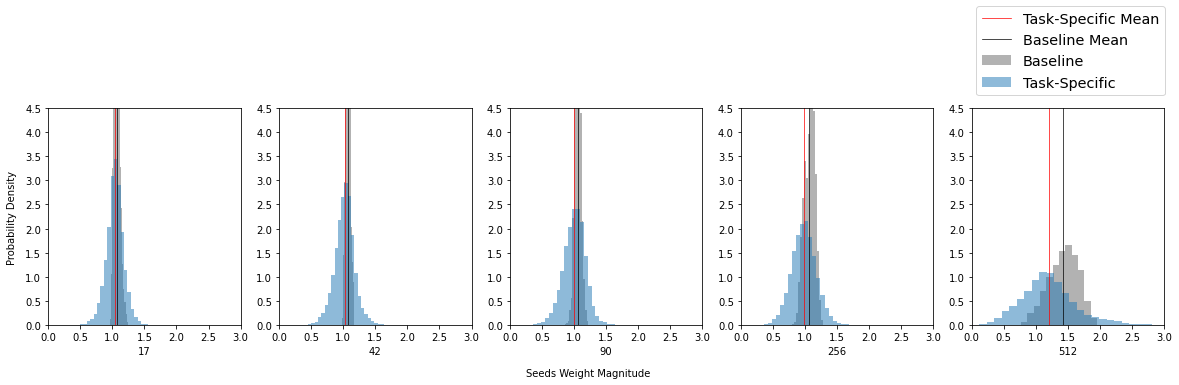

In [32]:
for k,v in s.items():
    s[k] = [item for sublist in v for item in sublist]
for k,v in p.items():
    p[k] = [item for sublist in v for item in sublist]
for k,v in s_b.items():
    s_b[k] = [item for sublist in v for item in sublist]
for k,v in p_b.items():
    p_b[k] = [item for sublist in v for item in sublist]

std_p = []
std_pb = []
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,4))
axes = [ax1, ax2, ax3, ax4, ax5]

for i,d in enumerate(dims):
    axes[i].set_axisbelow(True)
    # axes[i].yaxis.grid(color='gray', linestyle='dashed')
    # axes[i].xaxis.grid(color='gray', linestyle='dashed')
    axes[i].hist(p_b[d], bins=15, density=True, alpha=0.6, label='Baseline', color='grey')
    axes[i].hist(p[d], bins=30, density=True, alpha=0.5, label='Task-Specific',)
    axes[i].set_xlabel(str(d))
    axes[i].set_xlim([0, 3])
    axes[i].set_ylim([0, 4.5])
    axes[i].axvline(x=np.mean(p[d]), color='r', linewidth=0.7, label='Task-Specific Mean')
    axes[i].axvline(x=np.mean(p_b[d]), color='black', linewidth=0.7, label='Baseline Mean')
    std_p.append(np.std(p[d]))
    std_pb.append(np.std(p_b[d]))
    
fig2.text(0.5, -0.04, 'Seeds Weight Magnitude', ha='center', va='center')
fig2.text(0.1, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
#fig2.legend(fontsize='small', labels=['Task-Specific Mean', 'Baseline Mean', 'Baseline', 'Task-Specific'], bbox_to_anchor=[0.95,0.85])
axes[i].legend(fontsize='x-large', loc='upper right', bbox_to_anchor=(1.04, 1.5))
fig2.savefig(f'attention_spread.png', bbox_inches='tight', dpi=300)
    
print(std_pb, std_p)

In [59]:
import scipy

[0.6429527800926137, 0.9674961635597963, 0.9678506445938077, 0.7687946108204474, 0.09959786706943252] [3.955750020859181, 4.480606531445803, 3.9024424553986377, 2.702727780050043, 0.13355702865728197]


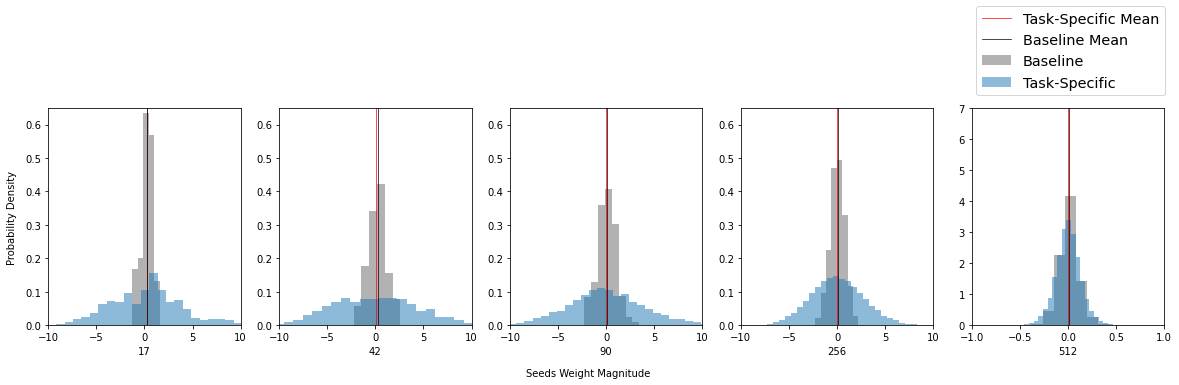

In [31]:
std_s = []
std_sb = []
b_b = [5, 6, 8,8,8]
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,4))
axes = [ax1, ax2, ax3, ax4, ax5]
for i, d in enumerate(dims):
    axes[i].set_axisbelow(True)
    # axes[i].yaxis.grid(color='gray', linestyle='dashed')
    # axes[i].xaxis.grid(color='gray', linestyle='dashed')
    axes[i].hist(s_b[d], bins=b_b[i], density=True, alpha=0.6, label='Baseline', color='grey', )
    axes[i].hist(s[d], bins=30, density=True, alpha=0.5, label='Task-Specific',)
    axes[i].set_xlim([-1, 1] if d==512 else [-10, 10])
    axes[i].set_ylim([0, 7] if d==512 else [0, 0.65])
    axes[i].set_xlabel(str(d))
    axes[i].axvline(x=np.mean(s[d]), color='r', linewidth=0.7, label='Task-Specific Mean')
    axes[i].axvline(x=np.mean(s_b[d]), color='black', linewidth=0.7, label='Baseline Mean')
    std_s.append(np.std(s[d]))
    std_sb.append(np.std(s_b[d]))

fig2.text(0.5, -0.04, 'Seeds Weight Magnitude', ha='center', va='center')
fig2.text(0.1, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
# axes[i].set_xlabel('Projected Attention Weight Magnitude')
# axes[i].set_ylabel('Probability Density')
#fig2.legend(fontsize='small', labels=['Task-Specific Mean', 'Baseline Mean', 'Baseline', 'Task-Specific'], bbox_to_anchor=[0.95,0.85])
axes[i].legend(fontsize='x-large', loc='upper right', bbox_to_anchor=(1.04, 1.5))
fig2.savefig(f'seed_spread.png', bbox_inches='tight', dpi=300)
print(std_sb, std_s)

In [62]:
for pair in [[17,42], [42,90], [90,256], [256,512]]:
    print(scipy.stats.spearmanr(p[pair[0]], p[pair[1]]))
for pair in [[17,42], [42,90], [90,256], [256,512]]:
    print(scipy.stats.spearmanr(p_b[pair[0]], p_b[pair[1]]))

SpearmanrResult(correlation=0.5590341382180067, pvalue=0.0)
SpearmanrResult(correlation=0.5506727637944752, pvalue=0.0)
SpearmanrResult(correlation=0.4059687415806973, pvalue=0.0)
SpearmanrResult(correlation=0.2556729435670416, pvalue=0.0)
SpearmanrResult(correlation=0.3476586192936679, pvalue=5.430042661653434e-16)
SpearmanrResult(correlation=0.4749498603815474, pvalue=3.612670697864645e-30)
SpearmanrResult(correlation=0.3231041537920143, pvalue=6.62450834906289e-14)
SpearmanrResult(correlation=0.22882441549078178, pvalue=1.6528785130369358e-07)


In [22]:
from scipy import stats

Per-filter analysis

In [ ]:
f_dict = {d:{i:[] for i in range(512)} for d in dims}
f_dict_b = {d:{i:[] for i in range(512)} for d in dims}

for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias)
        for i in range(512):
            f_dict[dim][i].append(pj[i])
    
    # Baselines
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias)
    for i in range(512):
        f_dict_b[dim][i].append(pj[i])

In [ ]:
f_dict_m = {d:{i:[] for i in range(512)} for d in dims}
f_dict_b_m = {d:{i:[] for i in range(512)} for d in dims}

for k,v in f_dict_m.items():
    for j,p in f_dict_m[k].items():
        f_dict_m[k][j] = [np.mean(f_dict[k][j]), np.std(f_dict[k][j])]
for k,v in f_dict_b_m.items():
    for j,p in f_dict_b_m[k].items():
        f_dict_b_m[k][j] = [np.mean(f_dict_b[k][j]), np.std(f_dict_b[k][j])]

In [ ]:
std_s = []
std_sb = []
b_b = [5, 6, 8,8,8]
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,4))
axes = [ax1, ax2, ax3, ax4, ax5]



for i, d in enumerate(dims):
    axes[i].set_axisbelow(True)
    # axes[i].yaxis.grid(color='gray', linestyle='dashed')
    # axes[i].xaxis.grid(color='gray', linestyle='dashed')
    axes[i].
    # axes[i].set_xlim([-1, 1] if d==512 else [-10, 10])
    # axes[i].set_ylim([0, 7] if d==512 else [0, 0.65])
    axes[i].set_xlabel(str(d))
    axes[i].axvline(x=np.mean(s[d]), color='r', linewidth=0.7, label='Task-Specific Mean')
    axes[i].axvline(x=np.mean(s_b[d]), color='black', linewidth=0.7, label='Baseline Mean')
    std_s.append(np.std(s[d]))
    std_sb.append(np.std(s_b[d]))

fig2.text(0.5, -0.05, 'Seeds Weight Magnitude', ha='center', va='center')
fig2.text(0.1, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
# axes[i].set_xlabel('Projected Attention Weight Magnitude')
# axes[i].set_ylabel('Probability Density')
#fig2.legend(fontsize='small', labels=['Task-Specific Mean', 'Baseline Mean', 'Baseline', 'Task-Specific'], bbox_to_anchor=[0.95,0.85])
axes[i].legend(fontsize='x-small',)
fig2.savefig(f'seed_spread.png', dpi=300)
print(std_sb, std_s)

In [ ]:
for d in dims:
    fig, ax2[0] = plt.subplots(figsize=(20,5))
    ax2[0].set_axisbelow(True)
    ax2[0].errorbar([n for n in f_dict[d].keys()], [m[0] for m in f_dict[d].values()], yerr=[m[1] for m in f_dict[d].values()], fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)
    ax2[0].grid(color='lightgrey', linestyle='-', axis='y')
    ax2[0].set_xlabel('Seed Dimensionality')
    ax2[0].set_ylabel('Accuracy Change')
    # fig.savefig('acc_change_per_all_dims.png', dpi=300)

In [ ]:
d_m = {i:[] for i in range(512)} 
d_b_m = {i:[] for i in range(512)} 

for k,v in f_dict_m.items():
    for j,p in f_dict_m[k].items():
        d_m[j].append(p[0])
for k,v in f_dict_b_m.items():
    for j,p in f_dict_b_m[k].items():
        d_b_m[j].append(p[0])
for k,v in d_m.items():
    d_m[k] = np.mean(d_m[k])
for k,v in d_b_m.items():
    d_b_m[k] = np.mean(d_b_m[k])

In [ ]:
fig, ax2[0] = plt.subplots(figsize=(20,5))
ax2[0].set_axisbelow(True)
ax2[0].scatter(list(d_m.keys()), list(d_m.values()))
ax2[0].grid(color='lightgrey', linestyle='-', axis='y')
ax2[0].set_xlabel('Seed Dimensionality')
ax2[0].set_ylabel('Accuracy Change')
ax2[0].set_ylim([0, 1.2])
# fig.savefig('acc_change_per_all_dims.png', dpi=300)

In [ ]:
s_w = {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}
s_w_b =  {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}

for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds)
        for i in range(dim):
            s_w[dim][i].append(pj[i])
    
    # Baselines
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    pj = np.squeeze(model.get_layer('attention_block5_conv1').seeds)
    for i in range(dim):
        s_w_b[dim][i].append(pj[i])

f_dict_m = {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}
f_dict_b_m = {j:{i:[] for i in range(j)} for j in [17, 42, 90, 256, 512]}

for k,v in s_w.items():
    for j,p in s_w[k].items():
        f_dict_m[k][j] = [np.mean(s_w[k][j]), np.std(s_w[k][j])]
for k,v in s_w_b.items():
    for j,p in s_w_b[k].items():
        f_dict_b_m[k][j] = [np.mean(s_w_b[k][j]), np.std(s_w_b[k][j])]

In [ ]:
for d in dims:
    fig, ax2[0] = plt.subplots(figsize=(20,5))
    ax2[0].set_axisbelow(True)
    ax2[0].errorbar([n+1 for n in s_w[d].keys()], [m[0] for m in s_w[d].values()], yerr=[m[1] for m in s_w[d].values()], fmt='o', color='red', ecolor='black', elinewidth=1.5, markersize=3)
    ax2[0].grid(color='lightgrey', linestyle='-', axis='y')
    ax2[0].set_xlabel('Seed Dimensionality')
    ax2[0].set_ylabel('Accuracy Change')
    # fig.savefig('acc_change_per_all_dims.png', dpi=300)